### 1.Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

#### 1.1 HOG features

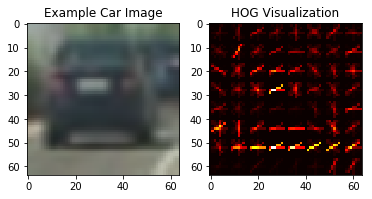

In [62]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from lesson_functions import *
import cv2

image = mpimg.imread('./vehicles/GTI_Far/image0000.png')

copy_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

# Define HOG parameters
orient = 8
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(copy_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

plt.imsave('./output_images/hog.jpg', hog_image, cmap='hot')

# Plot the examples
fig = plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='hot')
plt.title('HOG Visualization')

plt.show()

#### 1.2 Train the classifier

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *

import glob

cars = glob.glob('./vehicles/GTI_Far/*.png')
cars += glob.glob('./vehicles/GTI_MiddleClose/*.png')
cars += glob.glob('./vehicles/GTI_Left/*.png')
cars += glob.glob('./vehicles/GTI_Right/*.png')
cars += glob.glob('./vehicles/KITTI_extracted/*.png')
notcars = glob.glob('./non-vehicles/Extras/*.png')
notcars += glob.glob('./non-vehicles/GTI/*.png')

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [43]:
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split  
import glob

cars = glob.glob('./vehicles/GTI_Far/*.png')
cars += glob.glob('./vehicles/GTI_MiddleClose/*.png')
cars += glob.glob('./vehicles/GTI_Left/*.png')
cars += glob.glob('./vehicles/GTI_Right/*.png')
cars += glob.glob('./vehicles/KITTI_extracted/*.png')
notcars = glob.glob('./non-vehicles/Extras/*.png')
notcars += glob.glob('./non-vehicles/GTI/*.png')

### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
19.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


#### 1.3 Save the trainning result

In [3]:
# comment to avoid executing accidentally
# pickle_file = 'svc_pickle.p'
# print('Saving data to pickle file...')
# try:
#     with open(pickle_file, 'wb') as pfile:
#         pickle.dump(
#             {   'svc':svc, 
#                 'scaler': X_scaler,
#                 'color_space': color_space,
#                 'spatial_size': spatial_size,
#                 'hist_bins': hist_bins,
#                 'orient': orient,
#                 'pix_per_cell': pix_per_cell,
#                 'cell_per_block': cell_per_block,
#                 'hog_channel': hog_channel,
#                 'spatial_feat': spatial_feat,
#                 'hist_feat': hist_feat,
#                 'hog_feat':hog_feat
#             },
#             pfile, pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to', pickle_file, ':', e)
#     raise

#### 1.4 Multi-scale sliding window

In [4]:
from lesson_functions import *
def get_multi_scale_windows(image):
    all_windows = []

    window_sizes = [160, 128, 96, 64]
    for window_size in window_sizes:
        y_start_stop = [350, 700]
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(window_size, window_size), xy_overlap=(0.75, 0.75))

        all_windows += windows  
    
    return all_windows

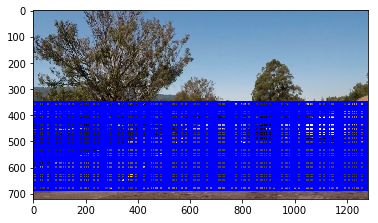

In [65]:
image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

all_windows = get_multi_scale_windows(image)

window_img = draw_boxes(draw_image, all_windows, color=(0, 0, 255), thick=6)                    

plt.imsave("./output_images/multi-scale-window.jpg", window_img)
plt.imshow(window_img)

plt.show()

#### 1.5 Combine overlapping detections and remove false positives with heatmap

In [69]:
data_file = './svc_pickle.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def get_heatmap(image, hot_windows, threshold):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return heatmap

def find_cars(image,i):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    all_windows = get_multi_scale_windows(image)
    
    # Search for cars
    hot_windows = search_windows(image, all_windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)  
    
    
    hot_box = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
    
    # Generate heatmap
    heatmap = get_heatmap(image, hot_windows, 2)
    
    # Label cars
    labels = label(heatmap)
    labeled_cars = draw_labeled_bboxes(np.copy(image), labels)    
    
    fig = plt.figure(figsize=(16,12))

    plt.subplot(131)
    plt.imshow(hot_box)
    plt.imsave("./output_images/hot_box_%s.jpg"%i, hot_box)
    plt.title('Hot boxs')
    
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.imsave("./output_images/heatmap_%s.jpg"%i, heatmap)
    plt.title('HeatMap')
    
    plt.subplot(133)
    plt.imshow(labeled_cars)
    plt.imsave("./output_images/labeled_cars_%s.jpg"%i, labeled_cars)
    plt.title('Cars')
    
    fig.tight_layout()
    
    plt.show()

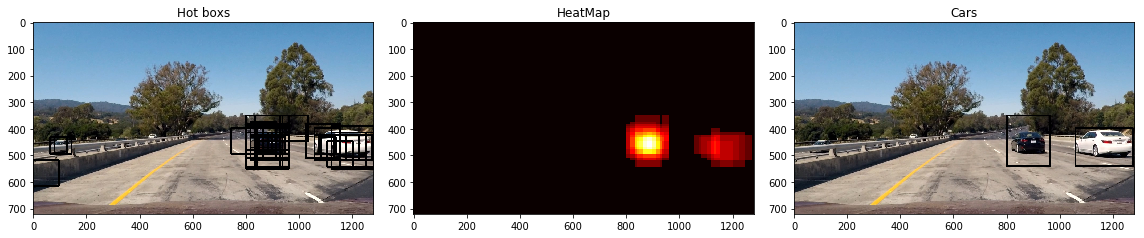

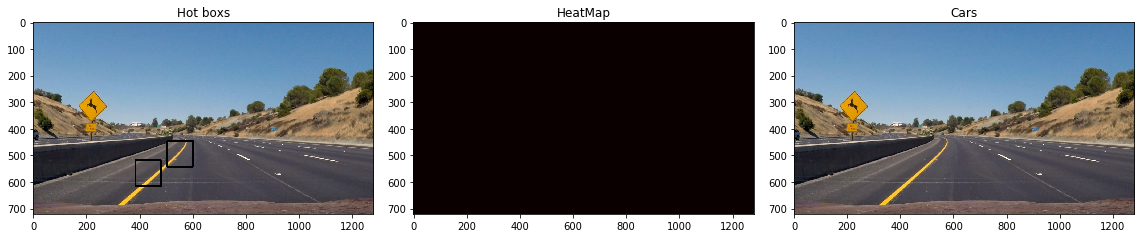

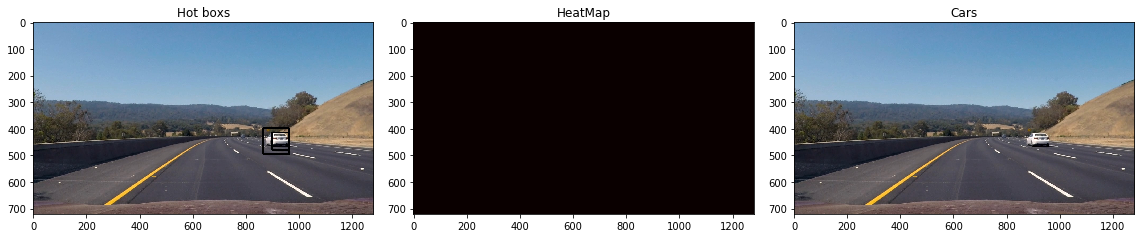

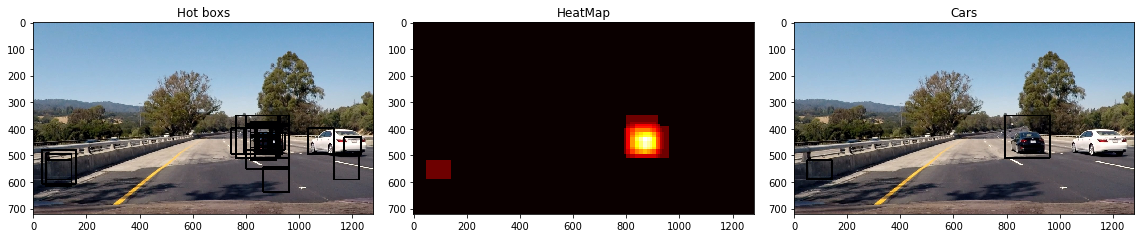

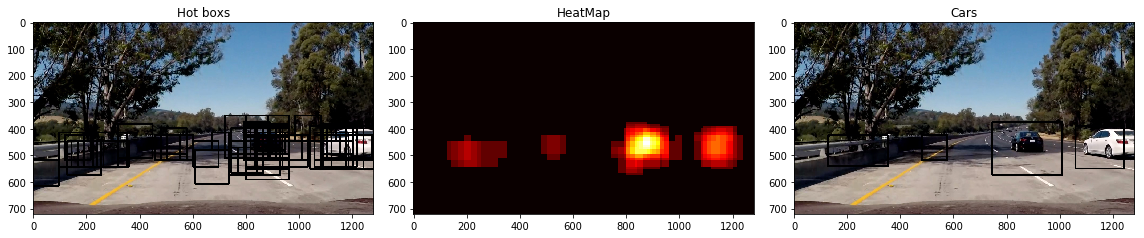

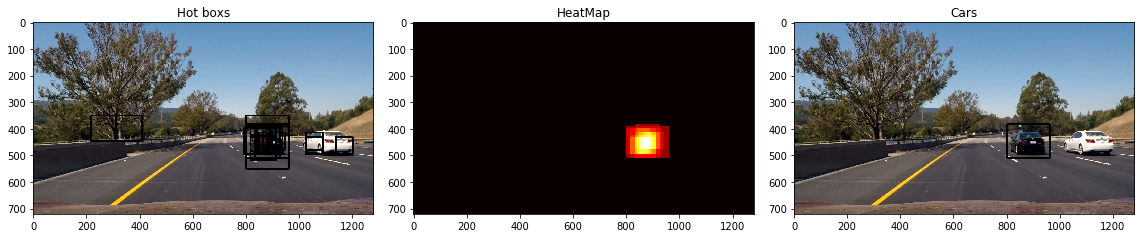

In [70]:

files = glob.glob('./test_images/test*.jpg')
i=0
for file in files:
    i+=1
    image = mpimg.imread(file)
    find_cars(image,i)

#### 1.6 Use hog Sub-sampling Window Search instead

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

ystart = 400
ystop = 656
scale = 1.5

# Define a single function that can extract features using hog sub-sampling and make predictions
def get_sub_sampling_windows(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HLS')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                
    return hot_windows
    

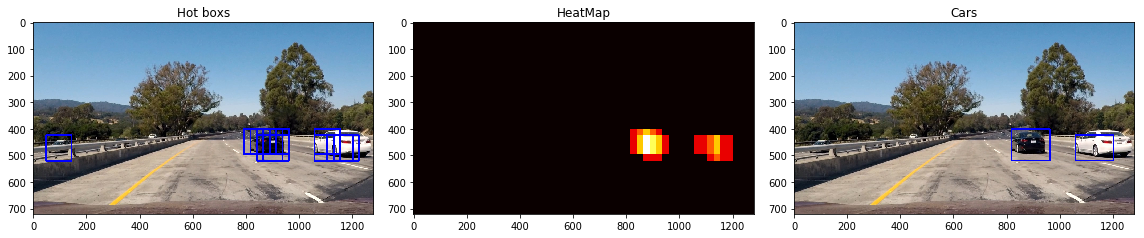

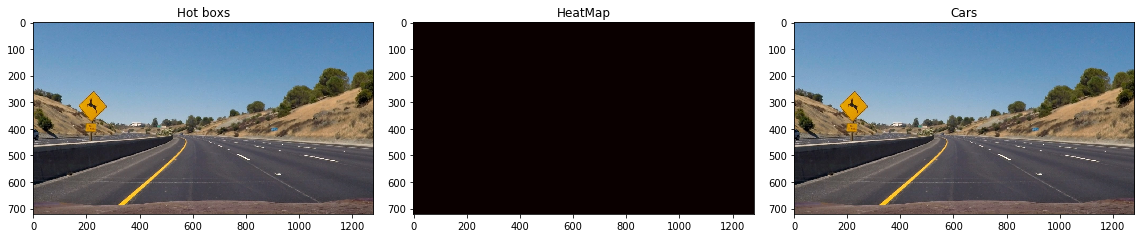

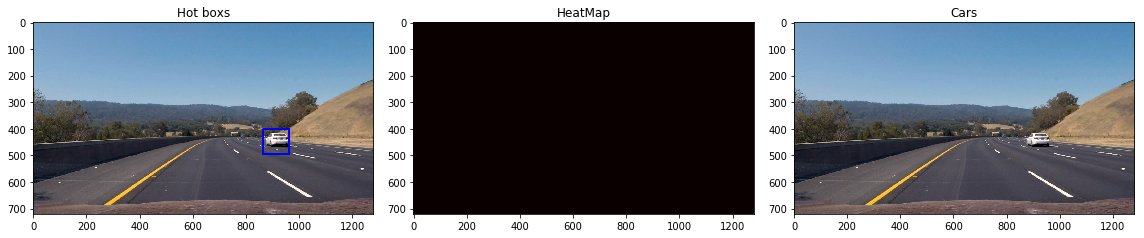

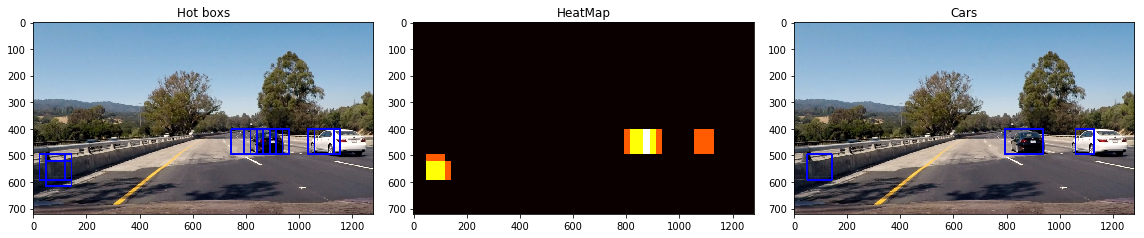

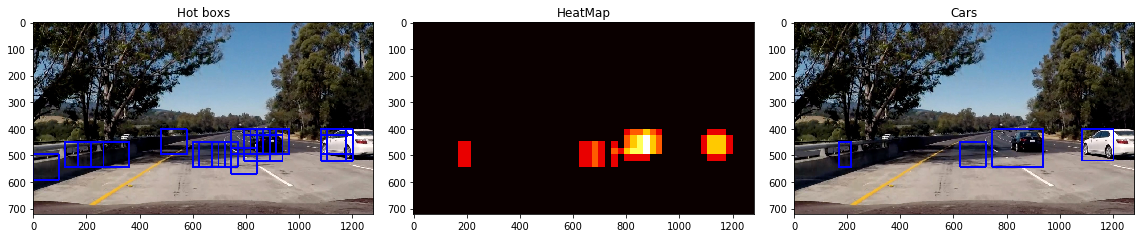

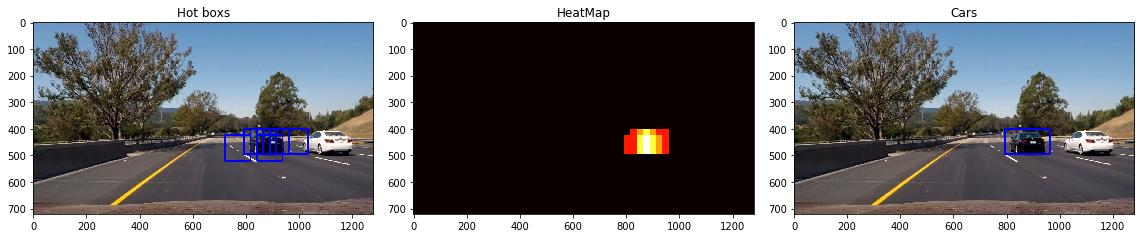

In [41]:
files = glob.glob('./test_images/test*.jpg')
for file in files:
    image = mpimg.imread(file)
    hot_windows = get_sub_sampling_windows(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    hot_box = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
    
    # Generate heatmap
    heatmap = get_heatmap(image, hot_windows, 1)
    
    # Label cars
    labels = label(heatmap)
    labeled_cars = draw_labeled_bboxes(np.copy(image), labels)    
    
    fig = plt.figure(figsize=(16,12))

    plt.subplot(131)
    plt.imshow(hot_box)
    plt.title('Hot boxs')
    
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('HeatMap')
    
    plt.subplot(133)
    plt.imshow(labeled_cars)
    plt.title('Cars')
    
    fig.tight_layout()
    
    plt.show()

### Video pipeline

In [49]:
from collections import deque

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        
    # Return the image
    return bboxes

# Grab the main idea from this blog https://stkexchange.wordpress.com/2017/08/21/vehicle-detection/
class Car():
    def __init__(self):
        # keep recent n frames bbox-detecting result
        self.n = 20
        self.recent_bboxes = deque([],maxlen=self.n)
        self.best_bbox = None 
    
    def is_real_car(self):
        if(len(self.recent_bboxes) < self.n):
            return False
        
        detected_bbox_num = 0
        for bbox in self.recent_bboxes:
            if bbox:
                detected_bbox_num += 1
        if detected_bbox_num < len(self.recent_bboxes)*0.6: # over 60% of frames detect the bbox, we predict it is a car
            return False
        else:
            return True
    
    def update_best_bbox(self):
        top = []
        left = []
        bottom = []
        right = []
        if(len(self.recent_bboxes)) > 0:
            for bbox in self.recent_bboxes:
                if bbox:
                    left.append(bbox[0][0])
                    top.append(bbox[0][1])
                    right.append(bbox[1][0])
                    bottom.append(bbox[1][1])

        aver_left = np.int(np.average(left))
        aver_top = np.int(np.average(top))
        aver_right = np.int(np.average(right))
        aver_bottom = np.int(np.average(bottom))
        self.best_bbox = ((aver_left, aver_top), (aver_right, aver_bottom))

# http://answers.opencv.org/question/59544/percentage-of-overlap/        
def percentage_of_overlap(bbox1, bbox2):
    # intersection point
    left = max(bbox1[0][0], bbox2[0][0])
    top = max(bbox1[0][1], bbox2[0][1])
    
    right = min(bbox1[1][0], bbox2[1][0])
    bottom = min(bbox1[1][1], bbox2[1][1])
    
    # check if the intersection is empty
    if (right < left or bottom < top):
        return 0
    
    intersection = (right - left) * (bottom - top)
    bbox1_area = (bbox1[1][0] - bbox1[0][0]) * (bbox1[1][1] - bbox1[0][1])
    bbox2_area = (bbox2[1][0] - bbox2[0][0]) * (bbox2[1][1] - bbox2[0][1])
    percentage = intersection / (bbox1_area + bbox2_area - intersection)
    return percentage

# find which "car" this bbox belongs to
def match_bbox_car(bbox, cars):
    best_match_pecentage = 0
    best_match_car = None
    for car in cars:
        car_bbox = car.best_bbox
        overlap_percentage = percentage_of_overlap(bbox, car_bbox)
        if overlap_percentage >= 0.4 and overlap_percentage > best_match_pecentage:
            best_match_pecentage = overlap_percentage
            best_match_car = car
    return best_match_car

car_list = []
def tracking(image, bboxes):
    global car_list
    # init the car list to initial value
    for car in car_list:
        car.recent_bboxes.appendleft(None)
    # check if bbox match any exist car
    for bbox in bboxes:
        car_matched = match_bbox_car(bbox, car_list)     
        if car_matched != None:
            car_matched.recent_bboxes[0] = bbox
            car_matched.update_best_bbox()
        else:
            # add candidate car
            car_candidate = Car()
            car_candidate.recent_bboxes.appendleft(bbox)
            car_candidate.update_best_bbox()
            car_list.append(car_candidate) 
            
    # choose the real car
    real_car_bboxes = []
    for car in car_list:
        if car.is_real_car():
            real_car_bboxes.append(car.best_bbox)
                    
    return draw_boxes(image, real_car_bboxes)

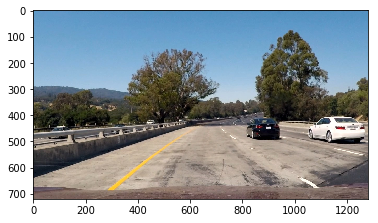

In [50]:
def process(image):
    hot_windows = get_sub_sampling_windows(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    hot_box = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
    
    # Generate heatmap
    heatmap = get_heatmap(image, hot_windows, 1)
    
    # Label cars
    labels = label(heatmap)

    #labeled_cars = draw_labeled_bboxes(np.copy(image), labels)
    
    # tracking car to remove false positive
    bboxes = get_labeled_bboxes(labels) 
    labeled_cars = tracking(image, bboxes)
    return labeled_cars

image = mpimg.imread('./test_images/test1.jpg')
labeled_cars_image = process(image)
plt.imshow(labeled_cars_image)
plt.show()


In [51]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

output_video = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("./project_video.mp4").subclip(5,15)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [08:06<00:00,  2.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 7min 36s, sys: 35.4 s, total: 8min 11s
Wall time: 8min 7s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))